In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets

import matplotlib.pyplot as plt

In [2]:
from tqdm.auto import tqdm 
from torchmetrics import Accuracy


In [3]:
train_data = datasets.FashionMNIST (
    "data", train=True, download=True, transform=ToTensor(), target_transform=None
)

test_data = datasets.FashionMNIST(
    "data", train=False, download=True, transform=ToTensor(), target_transform=None
)

In [4]:
print("Train data: ", len(train_data))
print("Test data: ", len(test_data))

Train data:  60000
Test data:  10000


Text(0.5, 1.0, 'torch.Size([1, 28, 28]) , 3')

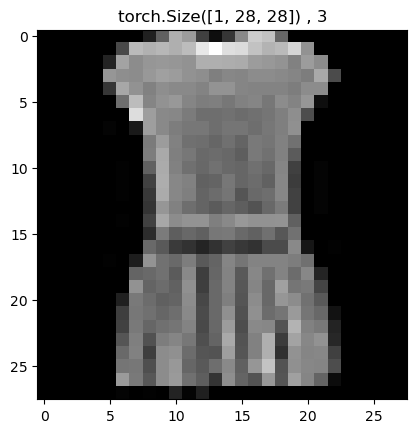

In [5]:
image , label = train_data[3]
plt.figure()
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"{image.shape} , {label}")

In [6]:
class_to_label = train_data.class_to_idx    
(class_to_label)
class_to_label = {v: k for k, v in class_to_label.items()}
print(class_to_label, len(class_to_label))

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'} 10


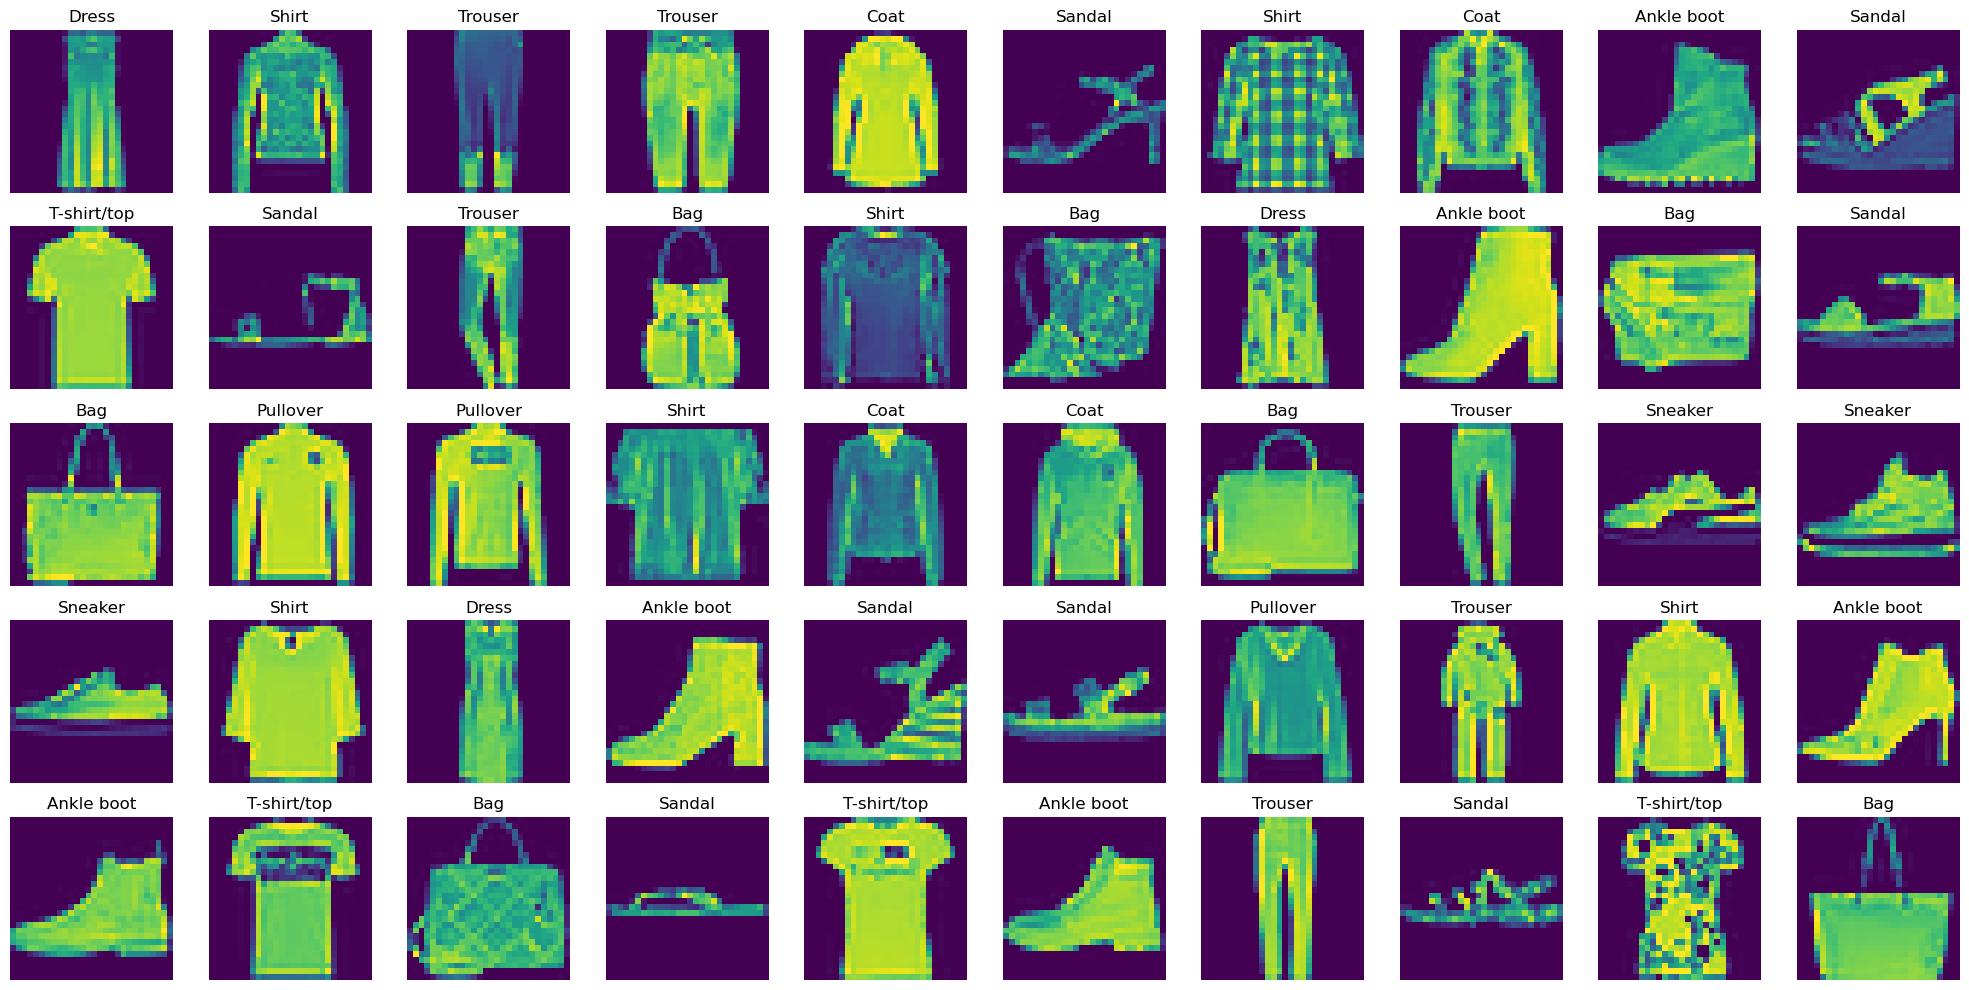

In [7]:
import random

# Set the number of images to display
num_images = 50

# Get random indices
random_indices = random.sample(range(len(train_data)), num_images)

# Plot the images in a 10x5 grid
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.flatten()
for ax, idx in zip(axes, random_indices):
    image, label = train_data[idx]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(class_to_label[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [9]:
print("Train data loader: ", len(train_data_loader))
print("Test data loader: ", len(test_data_loader))

Train data loader:  1875
Test data loader:  313


In [10]:
class FashionMNISTModel_v1(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_layers):
        super().__init__()

        self.Conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_layers,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_layers,
                out_channels=hidden_layers,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.Conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_layers,
                out_channels=hidden_layers,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_layers,
                out_channels=hidden_layers,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_layers * 7 *7, hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers, output_shape),
        )

    def forward(self, x):
        # print(x.shape)
        x = self.Conv_block1(x)
        # print(x.shape)
        x = self.Conv_block2(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [12]:
model_0 = FashionMNISTModel_v1(input_shape=1, output_shape=10, hidden_layers=32).to(device)

In [13]:
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

In [14]:
EPOCHS = 10


TRAIN_LOSS = []
TEST_LOSS = []

TRAIN_ACC = []
TEST_ACC = []

In [15]:
accuracy = Accuracy(task="multiclass", num_classes=10)

In [16]:
for epoch in tqdm(range(EPOCHS)):

    print(f"Epoch {epoch+1} of {EPOCHS} \n ------------------------------")
    train_epoch_loss = 0
    train_acc = 0
    

    for batch, (X, y) in enumerate(train_data_loader):

        y_pred = model_0(X.to(device))

        loss = loss_function(y_pred, y.to(device))

        train_acc += accuracy(y, torch.argmax(y_pred.cpu(), axis=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_epoch_loss += loss.item()

        # if batch % 100 == 0:
        #     print(f"Batch {batch} of {len(train_data_loader)}")

    train_epoch_loss = train_epoch_loss / len(train_data_loader)
    train_acc = train_acc / len(train_data_loader)

    TRAIN_LOSS.append(train_epoch_loss)
    TRAIN_ACC.append(train_acc)

    with torch.inference_mode():
        test_epoch_loss = 0
        test_acc = 0
        for X, y in test_data_loader:
            y_pred = model_0(X.to(device))
            loss = loss_function(y_pred, y.to(device))
            test_epoch_loss += loss.item()
            test_acc += accuracy(y, torch.argmax(y_pred.cpu(), axis=1))
            
        test_epoch_loss = test_epoch_loss / len(test_data_loader)
        test_acc = test_acc / len(test_data_loader)
        
        TEST_LOSS.append(test_epoch_loss)
        TEST_ACC.append(test_acc)
    
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_acc:.4f}")
    print("---------------------------------")
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 of 10 
 ------------------------------
Train Loss: 0.5080, Train Acc: 0.8137
Test Loss: 0.4543, Test Acc: 0.8277
---------------------------------

Epoch 2 of 10 
 ------------------------------
Train Loss: 0.3697, Train Acc: 0.8648
Test Loss: 0.3557, Test Acc: 0.8655
---------------------------------

Epoch 3 of 10 
 ------------------------------
Train Loss: 0.3531, Train Acc: 0.8690
Test Loss: 0.3817, Test Acc: 0.8553
---------------------------------

Epoch 4 of 10 
 ------------------------------
Train Loss: 0.3439, Train Acc: 0.8734
Test Loss: 0.3775, Test Acc: 0.8622
---------------------------------

Epoch 5 of 10 
 ------------------------------
Train Loss: 0.3467, Train Acc: 0.8702
Test Loss: 0.3821, Test Acc: 0.8608
---------------------------------

Epoch 6 of 10 
 ------------------------------
Train Loss: 0.3369, Train Acc: 0.8726
Test Loss: 0.3875, Test Acc: 0.8603
---------------------------------

Epoch 7 of 10 
 ------------------------------
Train Loss: 0.339

In [19]:
def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_function: torch.nn.Module,
    accuracy_function: callable,
):

    loss, acc = 0, 0

    model = model.to("cuda")

    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X.to("cuda"))
            loss += loss_function(y_pred, y.to("cuda")).item()
            acc += accuracy_function(y, torch.argmax(y_pred.cpu(), axis=1))

        loss = loss / len(data_loader)
        acc = acc / len(data_loader)

    return {"model_name ": model.__class__.__name__, "loss": loss, "accuracy": acc.item()}

In [20]:
eval_model(model_0, test_data_loader, loss_function, accuracy)

{'model_name ': 'FashionMNISTModel_v1',
 'loss': 0.36307786049220125,
 'accuracy': 0.8728035092353821}

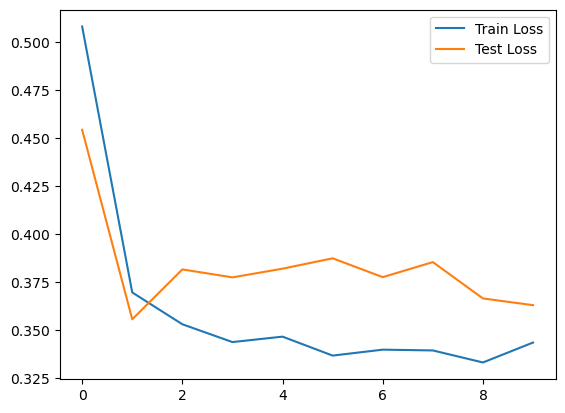

In [21]:
plt.plot(TRAIN_LOSS, label="Train Loss")
plt.plot(TEST_LOSS, label="Test Loss")
plt.legend()

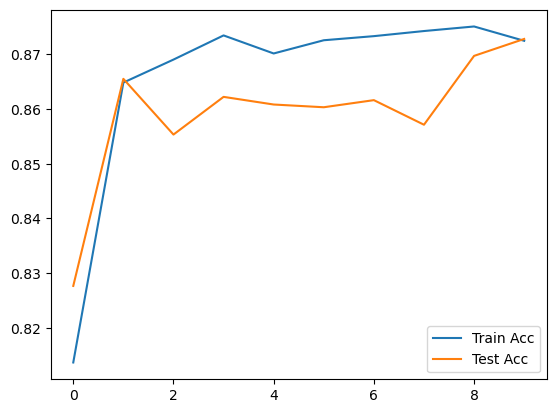

In [22]:
plt.plot(TRAIN_ACC, label="Train Acc")
plt.plot(TEST_ACC, label="Test Acc")
plt.legend()


In [28]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix 


In [33]:
with torch.inference_mode():
    y_pred_list = []
    y_true_list = []
    for X, y in test_data_loader:
        y_pred = model_0(X.to("cuda"))
        y_pred_list.append(torch.argmax(y_pred.cpu(), axis=1))
        y_true_list.append(y)

    y_pred_list = torch.cat(y_pred_list, axis=0)
    y_true_list = torch.cat(y_true_list, axis=0)

In [30]:
confusion_matrix = ConfusionMatrix(task="multiclass" , num_classes=10)

In [38]:
confusion_matrix = confusion_matrix.to("cuda")
matrix = confusion_matrix(y_pred_list.to(device), y_true_list.to(device))

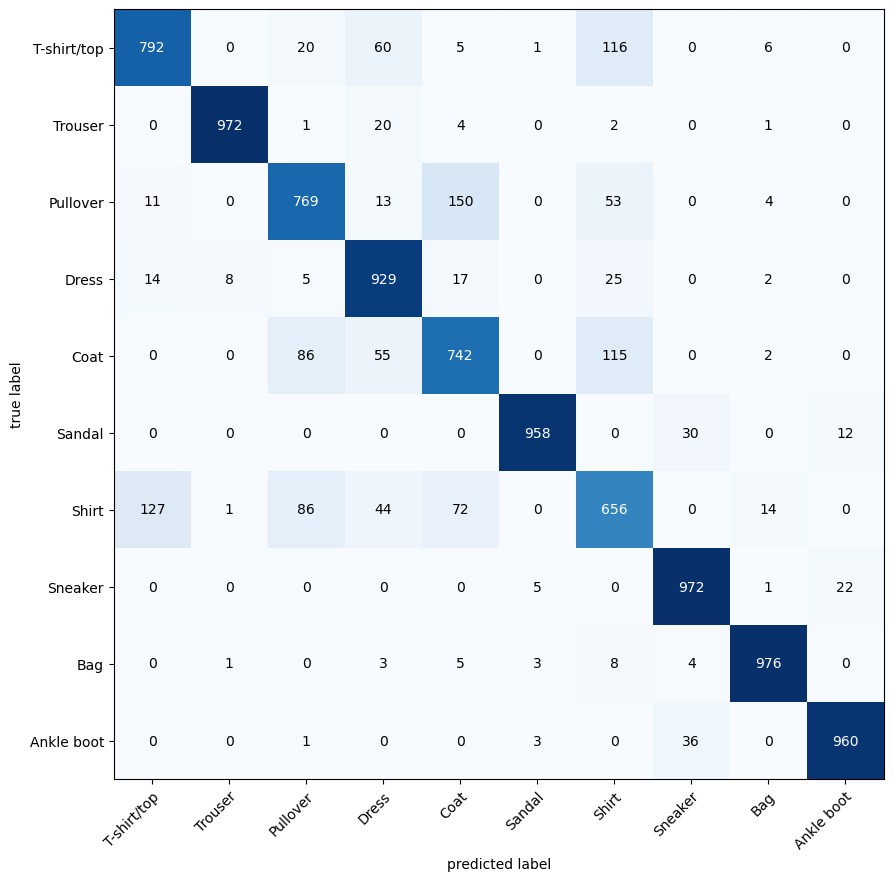

In [41]:
fig , ax = plot_confusion_matrix(matrix.cpu().numpy(), figsize=(10, 10), class_names=class_to_label.values())

In [43]:
torch.save(model_0, f"model/{model_0.__class__.__name__}.pt")

In [44]:
tempoModel = torch.load(f"model/{model_0.__class__.__name__}.pt")

C:\Users\pavan\AppData\Local\Temp\ipykernel_12628\2606786848.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tempoModel = torch.load(f"model/{model_0.__class__.__name__}

In [45]:
eval_model(tempoModel, test_data_loader, loss_function, accuracy)

{'model_name ': 'FashionMNISTModel_v1',
 'loss': 0.36307786049220125,
 'accuracy': 0.8728035092353821}